In [22]:
# import general packages
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
from scipy.optimize import brentq

import h5py
import json
import os
from datetime import datetime

import pde
import phasesep_pyrenoid as ph
from phasesep_pyrenoid.helper_functions import init_from_file, get_waistline_profile_fwhm, dimensionalize_params, get_initial_radius, cmap_exp, cmap_orange, dark_orange, colors, colors_exp, colors_phases, add_scalebar, add_timenote
from phasesep_pyrenoid.solvers_simulations import solve_stokes_flow, run_simulation
from droplets import DiffuseDroplet, Emulsion, SphericalDroplet, image_analysis

radius_micrometer = 1 # [micro meter]
shrinking_time = 10 # [minutes]

with open("./simulation_results/Paper/definite/charact_scales.json", "r") as f:
    charact_scales = json.load(f)
T_char, L_char, P_char = (charact_scales[k] for k in ("T_char", "L_char", "P_char"))

FOLDER_RESULTS = "./simulation_results/Paper/definite/asymmetric"
FOLDER_FIGURES= "./simulation_results/Paper/figures_for_paper/"

# Fig 5A

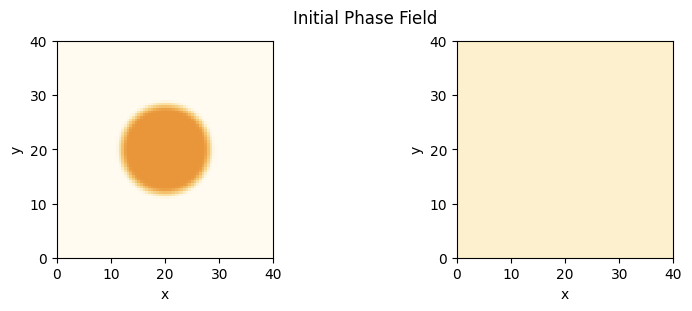

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [02:23<00:00,  1.40it/s]      
100%|██████████| 21/21 [00:01<00:00, 16.56it/s]


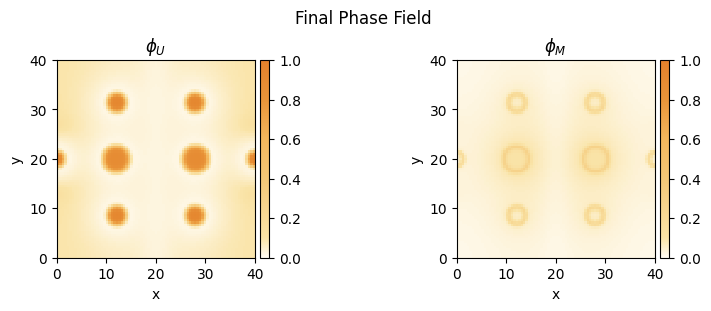

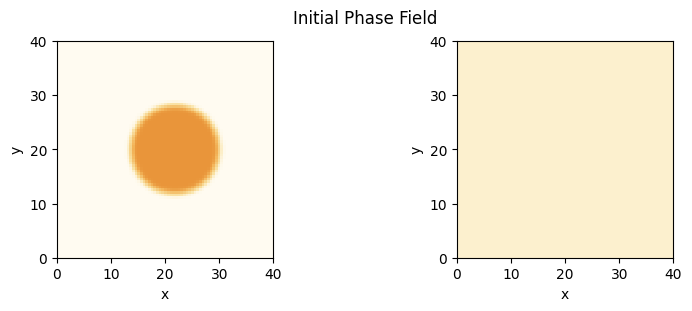

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [02:39<00:00,  1.26it/s]     
100%|██████████| 21/21 [00:01<00:00, 16.91it/s]


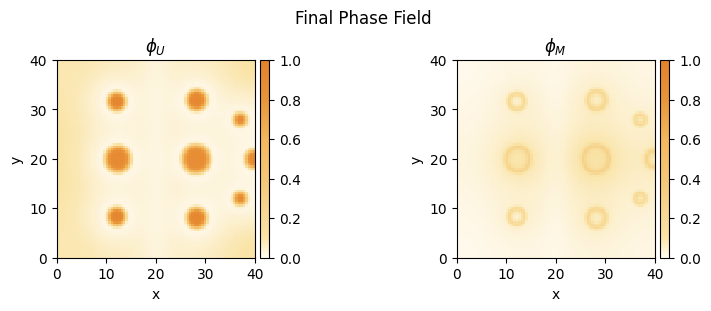

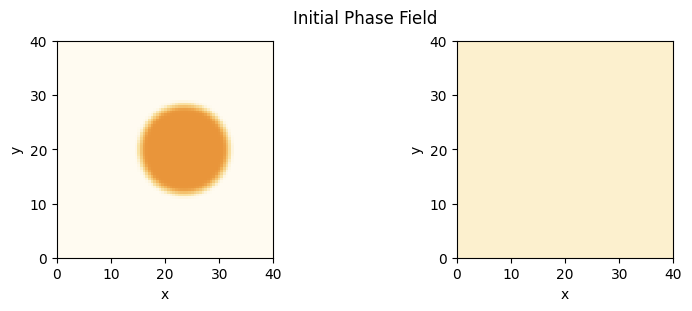

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [02:53<00:00,  1.15it/s]    
100%|██████████| 21/21 [00:01<00:00, 13.81it/s]


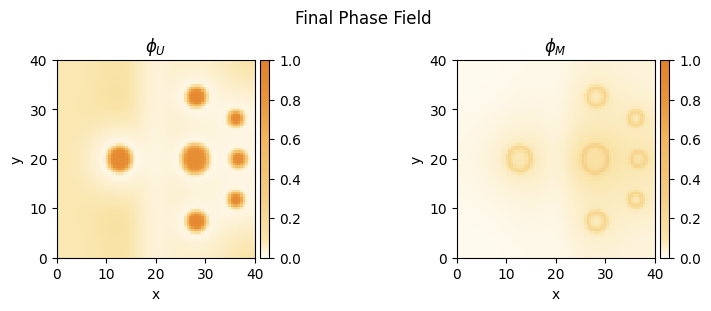

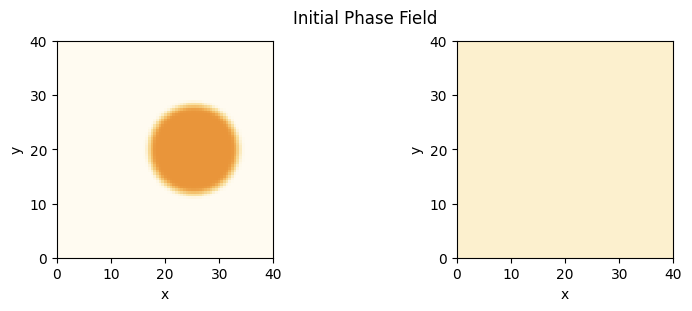

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [02:39<00:00,  1.26it/s]    
100%|██████████| 21/21 [00:01<00:00, 16.86it/s]


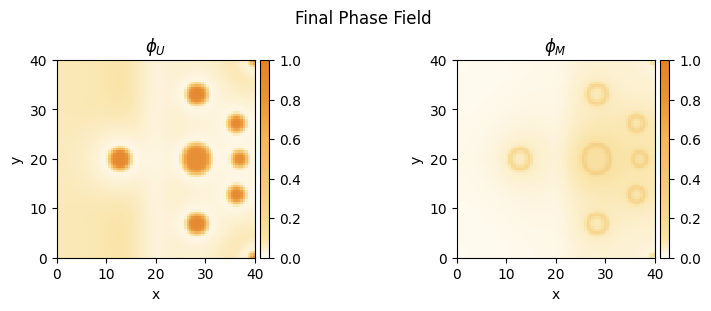

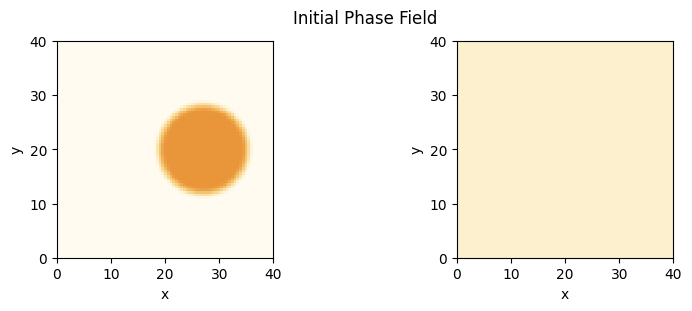

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [02:24<00:00,  1.39it/s]    
100%|██████████| 21/21 [00:01<00:00, 16.12it/s]


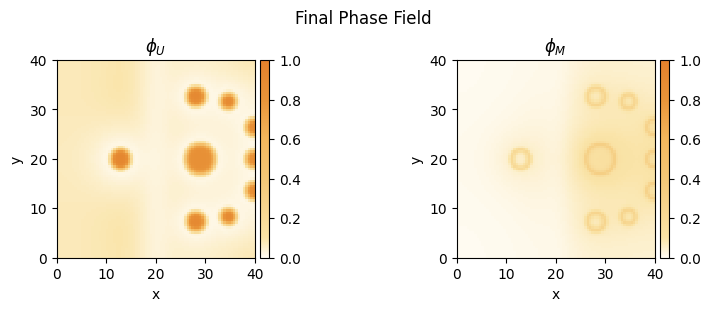

In [196]:
asym_levels = 5
x0s = np.linspace(20,27,asym_levels)
advec = [True]
for ind in range(asym_levels):
    num_phases = 1
    chem_reacts = [True]
    km_reacts = [0.03]
    chem_reacts_types = ["ext_maint"]
    start_from_input_files = [False]
    advec = [True]
    sim_times = [200]
    input_filename_vec = []

    for phase in range(num_phases):
        params_advection = {
            "nx": 83,
            "ny": 83,
            "Lx": 40.0,
            "Ly": 40.0,
            "mu": 40,
            "eta": 12.5,
            "P0": 10,
            "sigma_P": 1.2
        }

        chem_react = chem_reacts[phase]
        params = {
            "k_M": km_reacts[phase] if chem_react else 0,
            "k_U": 0.03 if chem_react else 0,
            "chem_react_type": chem_reacts_types[phase] if chem_react else "None",
            "xc" : 0.5,
            "b" : 200,
            "d" : 1, #9.6 
            "kappa": 1,
            "chi" : 5, # Positive = repulsion
            "shape" : 40,
            "size" : 81,
            "simulation_time" : sim_times[phase],
            "periodic_bc" : False,
            "interval_for_tracking" : 10,
            "advection": advec[phase]
        }

        start_from_input_file = start_from_input_files[phase]
        input_folder = input_filename_vec[phase-1] if start_from_input_file else None
        input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

        # Choose initial conditions for U and M
        selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
        selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

        # Define parameters separately for U and M
        PARAMS_INIT_U = {
            "from_file":{ "filename": input_filename,
                "suffix": "_U.hdf5"
            },
            "random": {
                "phi": 0.5,
                "std": 2e-4
            },
            "single_droplet": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "radius": 8,
                "position": [x0s[ind], 20]  # Relative to shape center
            },
            "emulsion": {
                "phi": 0.5,
                "droplets": [
                    {"position": [1/3, 1/3], "radius": 8},
                    {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
                ]
            }
        }

        PARAMS_INIT_M = {
                "from_file":{ "filename": input_filename,
                "suffix": "_M.hdf5",
            },
            "random": {
                "phi": 0.05,
                "std": 2e-4
            },
            "single_droplet": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "radius": 8,
                "position": [25, 25]  # Relative to shape center
            },
            "emulsion": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "droplets": [
                    {"position": [1/3, 1/3], "radius": 7.5},
                    {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
                ]
            }
        }


        save_final_config = True
        ### Save params ###
        if save_final_config:
            run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
            output_folder = f"simulation_results/Paper/definite/asymmetric/PTMs/{run_name}/"
            input_filename_vec.append(output_folder)
            os.makedirs(output_folder, exist_ok=True)

            with open(f"{output_folder}/params.json", "w") as f:
                json.dump(params, f, indent=4)
            if params["advection"]:
                with open(f"{output_folder}/params_advection.json", "w") as f:
                    json.dump(params_advection, f, indent=4)
        output_filename = output_folder+f"final_config"

        P, u, x, y, X, Y = solve_stokes_flow(**params_advection)

        sol, solver_info = run_simulation(selected_init_cond_U,
            selected_init_cond_M,
            PARAMS_INIT_U[selected_init_cond_U],
            PARAMS_INIT_M[selected_init_cond_M],
            save_final_config, input_filename, output_filename, output_folder, chem_react, u = u, cmapcolor = cmap_orange, **params)


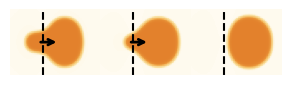

In [182]:
parent_dir = FOLDER_RESULTS+"/noPTMs/2025-09-30_07-46-33/"

storage_read = pde.FileStorage(parent_dir+"/final_config.hdf")
time_snaps = [70,190,230]
plt.figure(figsize=(3.5,2))
with open(parent_dir+'/init_cond_params.json') as f:
    init_cond_params = json.load(f)
    x0 = init_cond_params["U"]["position"][0]
    i = 1
for time1, UM_fields in storage_read.items():
    if time1 in time_snaps:
        plt.subplot(1,3,i)
        plt.imshow(np.transpose(UM_fields.data[0]), cmap = cmap_orange)
        plt.xlim(20,75)
        plt.ylim(20,60)
        plt.box(False)
        plt.xticks([])
        plt.yticks([])
        plt.vlines(40,0,80, linestyle = "--", color = "black")
        if i<3:
            arrow = patches.FancyArrowPatch((37, 40), (50, 40), arrowstyle='->', 
                            color='black', linewidth=2, mutation_scale=10)
            axs = plt.gca()
            axs.add_patch(arrow)
        i += 1
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(FOLDER_FIGURES+"small_lobe.svg", transparent = True)


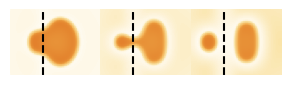

In [209]:
parent_dir = FOLDER_RESULTS+"/PTMs/2025-09-30_22-57-07/"

storage_read = pde.FileStorage(parent_dir+"/final_config.hdf")
time_snaps = [20, 50, 80]
plt.figure(figsize=(3.5,2))
i = 1
for time1, UM_fields in storage_read.items():
    if time1 in time_snaps:
        plt.subplot(1,3,i)
        plt.imshow(np.transpose(UM_fields.data[0]), cmap = cmap_orange)
        plt.xlim(20,75)
        plt.ylim(20,60)
        plt.box(False)
        plt.xticks([])
        plt.yticks([])
        plt.vlines(40,0,80, linestyle = "--", color = "black")
        i += 1
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(FOLDER_FIGURES+"small_lobePTMs.svg", transparent = True)


In [84]:
def asymmetry_metric(c, mid):

    # Sum over left and right
    M_left  = np.sum(c[0:mid])
    M_right = np.sum(c[mid:])
    
    # Asymmetry metric
    return abs(M_left - M_right) / (M_left + M_right)

In [195]:
parent_dir = FOLDER_RESULTS+"/noPTMs/"
sel_time = 1000
R0 = 7
A_par_list = []
delta_x = []
for name in os.listdir(parent_dir):
    full_path = os.path.join(parent_dir, name)
    if os.path.isdir(full_path):
        storage_read = pde.FileStorage(parent_dir+name+"/final_config.hdf")
        with open(parent_dir+name+'/init_cond_params.json') as f:
            init_cond_params = json.load(f)
            x0 = init_cond_params["U"]["position"][0]
        for time1, UM_fields in storage_read.items():
            if time1 == 1000:
                UM_field_tot = UM_fields.data[0]
                A_par_list.append(asymmetry_metric(UM_field_tot, 40))
    delta_x.append((x0-20)/R0)    

In [202]:
parent_dir = FOLDER_RESULTS+"/PTMs/"
sel_time = 200
R0 = 7
A_par_list_PTMs = []
delta_xPTMs = []
for name in os.listdir(parent_dir):
    full_path = os.path.join(parent_dir, name)
    if os.path.isdir(full_path):
        storage_read = pde.FileStorage(parent_dir+name+"/final_config.hdf")
        with open(parent_dir+name+'/init_cond_params.json') as f:
            init_cond_params = json.load(f)
            x0 = init_cond_params["U"]["position"][0]
        for time1, UM_fields in storage_read.items():
            if time1 == 200:
                UM_field_tot = UM_fields.data[0]
                A_par_list_PTMs.append(asymmetry_metric(UM_field_tot, 40))
    delta_xPTMs.append((x0-20)/R0)    

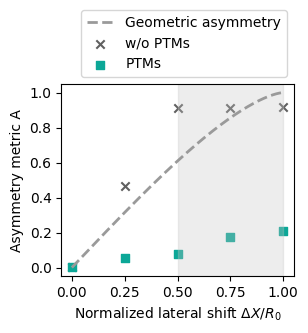

In [218]:
R = 1.0 # circle radius

# dx values
dx_values = np.linspace(0, R, 400) # lateral shift values

def area_left_circle(r, dx): 
    """Area of circle of radius r left of vertical line x=dx (dx in [0,r])"""
    if dx <= -r:
        return np.pi * r**2
    if dx >= r:
        return 0.0
    return r**2 * np.arccos(dx / r) - dx * np.sqrt(r**2 - dx**2)

# baseline (no PTMs): area left for full circle radius R
areas_left_baseline = np.array([area_left_circle(R, dx) for dx in dx_values])
asym_baseline = np.abs(areas_left_baseline - (np.pi * R**2 - areas_left_baseline)) / (np.pi * R**2)

# Plot
fig, ax = plt.subplots(figsize=(3,2.5))
plt.plot(dx_values / R, asym_baseline, label='Geometric asymmetry',linestyle='--',  lw=2, color="#9A9A9A")
plt.scatter(delta_x, A_par_list, marker = "x", color = "#606060", label = "w/o PTMs")
plt.scatter(delta_xPTMs, A_par_list_PTMs, marker = "s", color = "#0CA797", label = "PTMs")

plt.xlabel(r'Normalized lateral shift $\Delta X / R_0$')
x0, x1 = 0.5, 1
ax.axvspan(x0, x1, color="#C4C4C4", alpha=0.3)

plt.ylabel('Asymmetry metric A')
plt.legend()
ax.legend(
    loc='lower right',
    bbox_to_anchor=(1,1)  # (x, y) relative to axes
)

plt.savefig(FOLDER_FIGURES+"asymmetric.svg", transparent = True, bbox_inches = "tight")

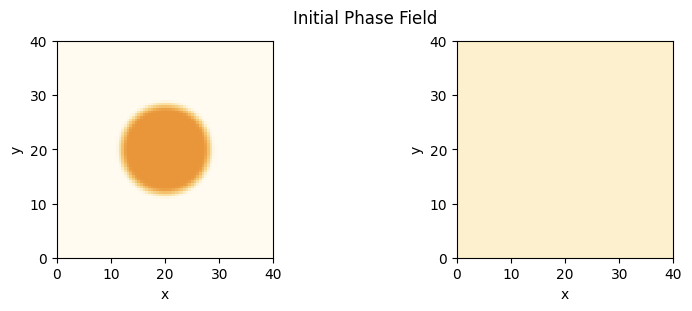

100%|██████████| 10.0/10.0 [00:11<00:00,  1.19s/it]   
100%|██████████| 11/11 [00:00<00:00, 16.00it/s]


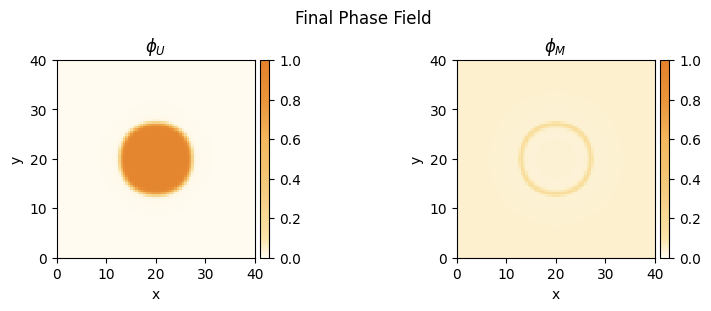

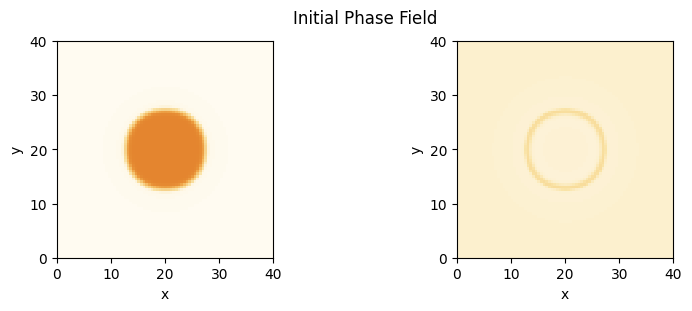

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 100.0/100.0 [01:05<00:00,  1.52it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.90it/s]


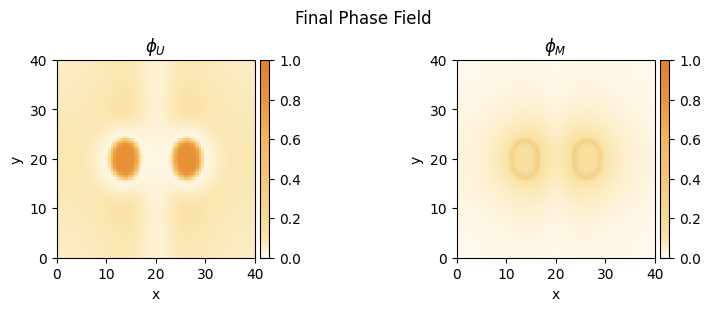

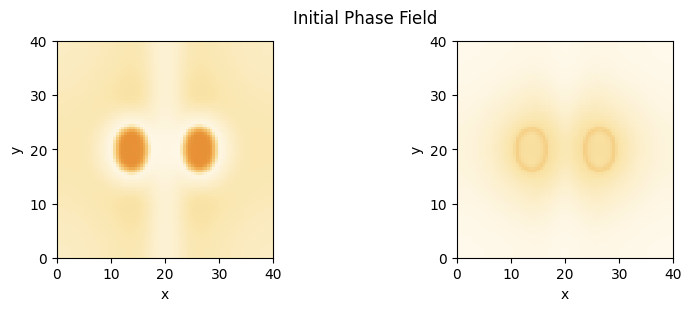

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [03:00<00:00,  1.11it/s]    
100%|██████████| 201/201 [00:10<00:00, 18.36it/s]


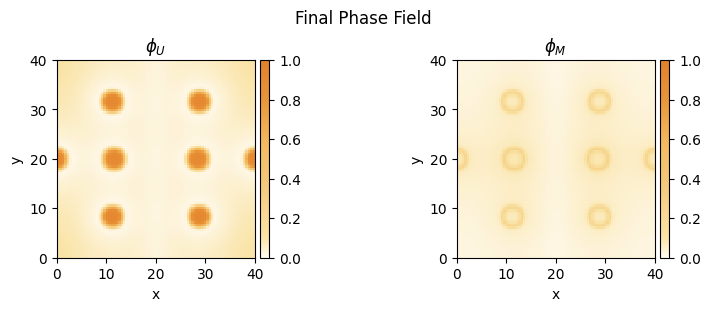

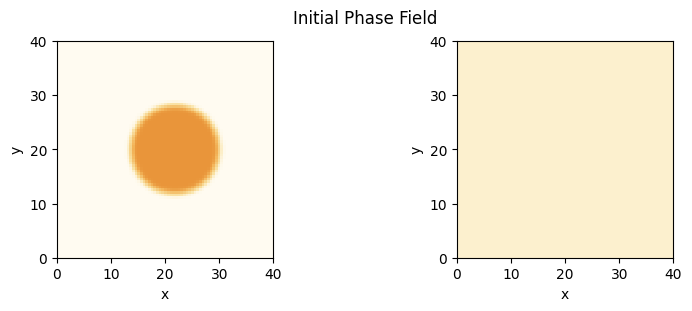

100%|██████████| 10.0/10.0 [00:11<00:00,  1.18s/it]   
100%|██████████| 11/11 [00:00<00:00, 15.84it/s]


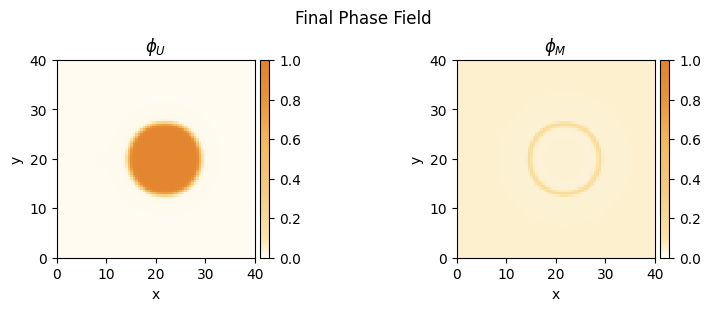

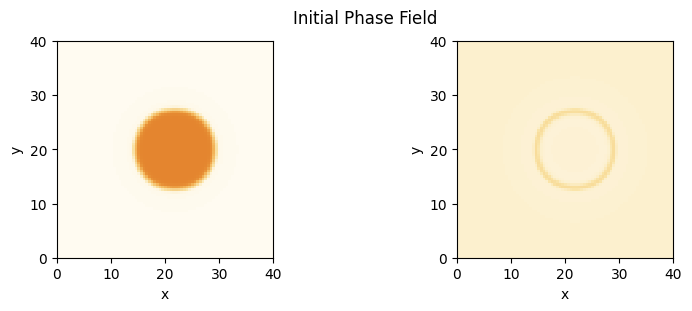

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 100.0/100.0 [01:10<00:00,  1.41it/s]    
100%|██████████| 101/101 [00:05<00:00, 18.06it/s]


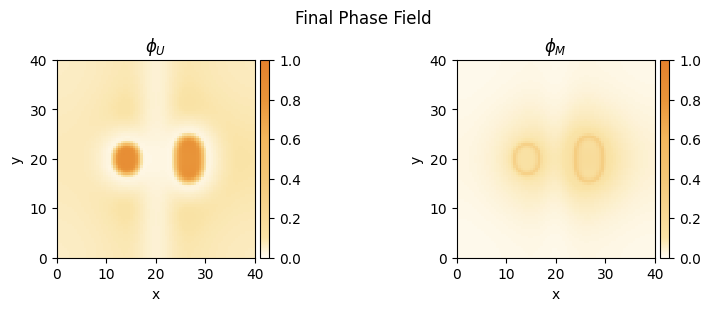

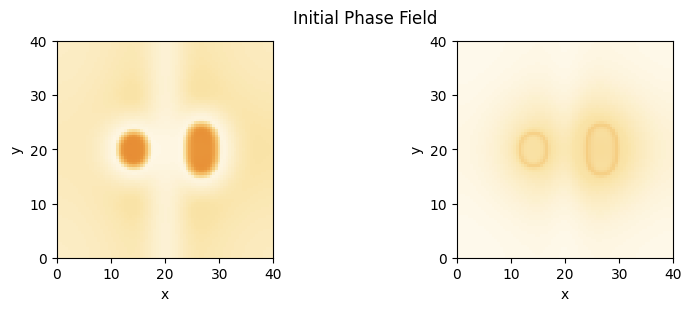

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [03:00<00:00,  1.11it/s]    
100%|██████████| 201/201 [00:11<00:00, 18.24it/s]


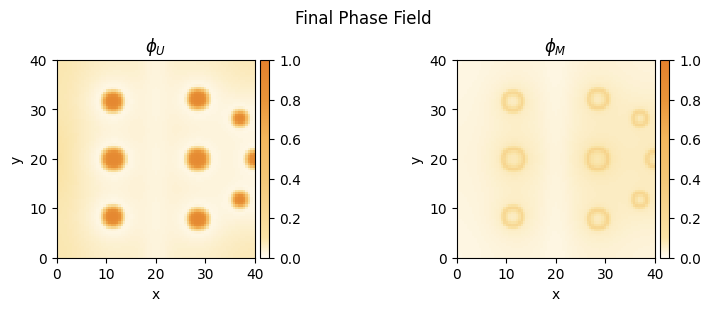

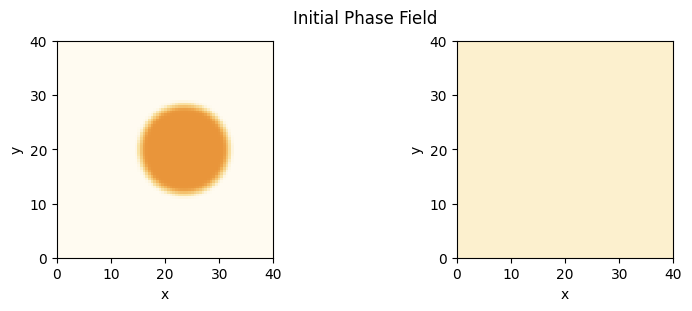

100%|██████████| 10.0/10.0 [00:11<00:00,  1.16s/it]   
100%|██████████| 11/11 [00:00<00:00, 15.61it/s]


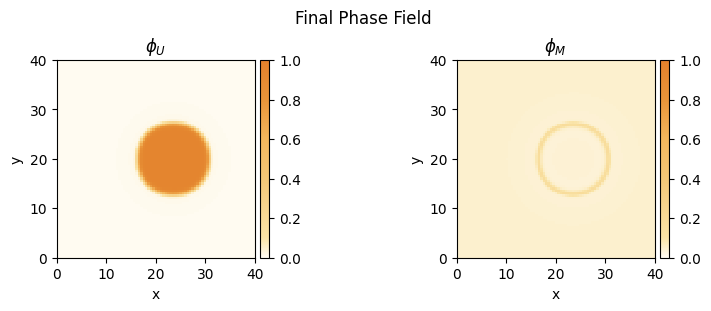

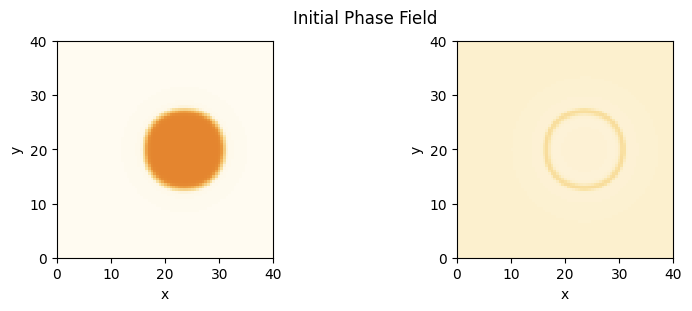

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 100.0/100.0 [01:19<00:00,  1.26it/s]    
100%|██████████| 101/101 [00:05<00:00, 18.20it/s]


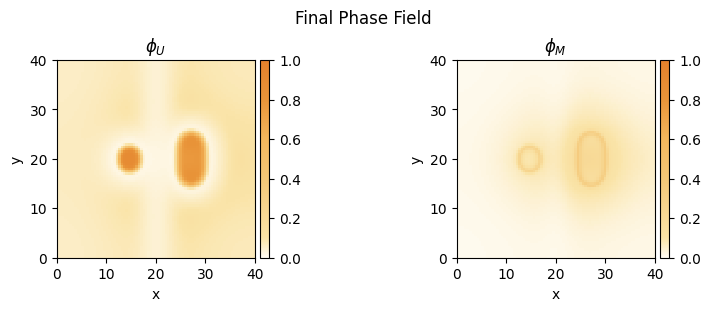

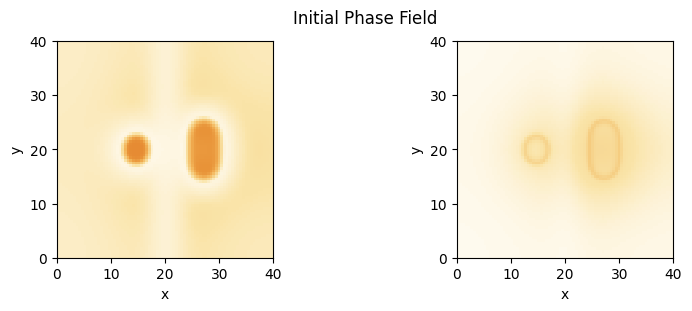

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [03:16<00:00,  1.02it/s]    
100%|██████████| 201/201 [00:11<00:00, 18.12it/s]


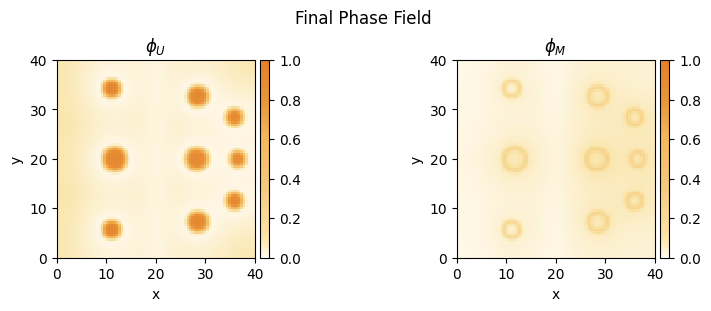

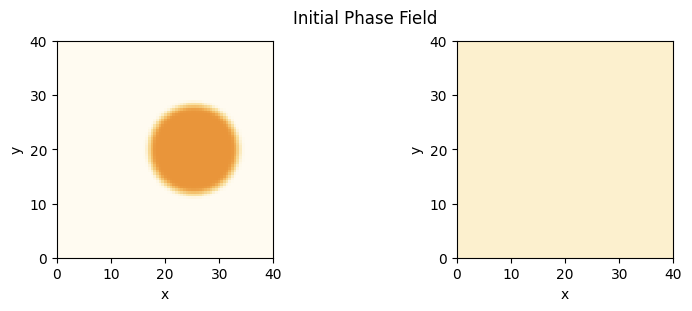

100%|██████████| 10.0/10.0 [00:10<00:00,  1.07s/it]   
100%|██████████| 11/11 [00:00<00:00, 12.00it/s]


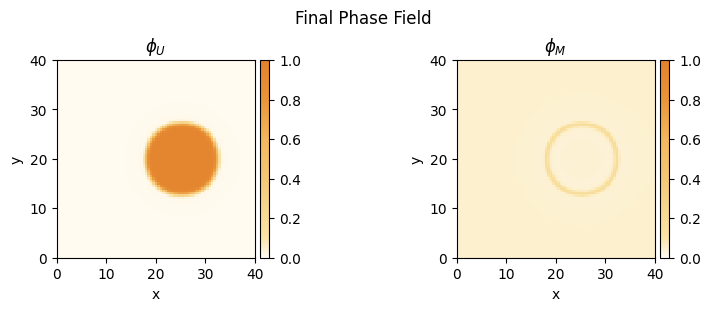

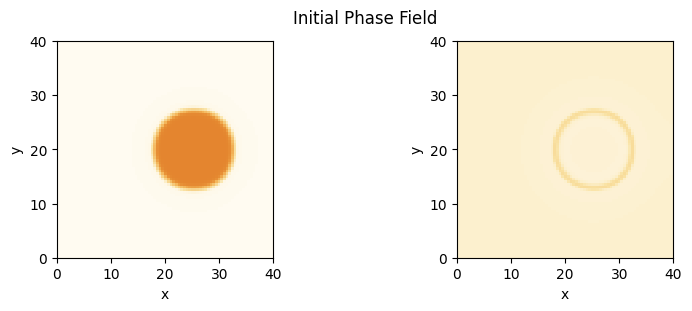

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 100.0/100.0 [01:04<00:00,  1.55it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.93it/s]


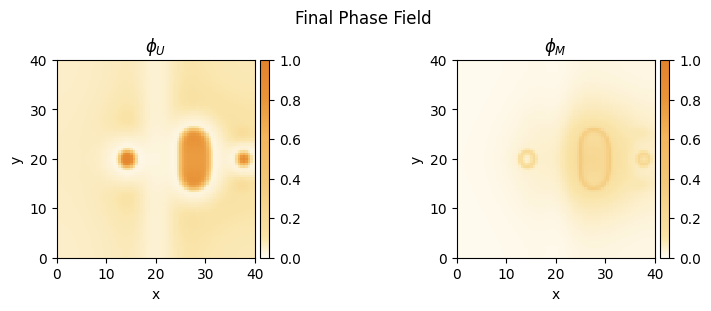

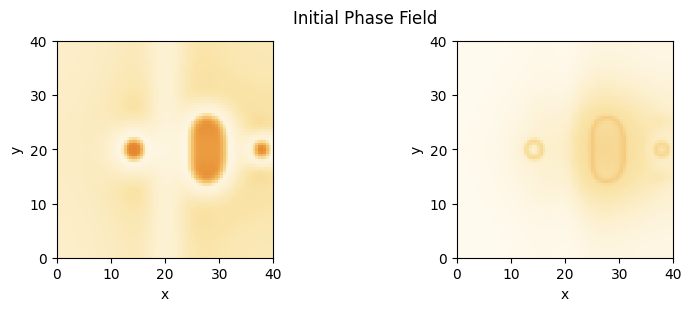

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [03:25<00:00,  1.03s/it]    
100%|██████████| 201/201 [00:10<00:00, 18.27it/s]


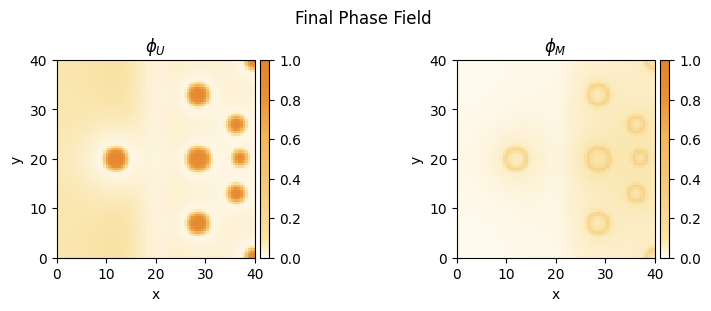

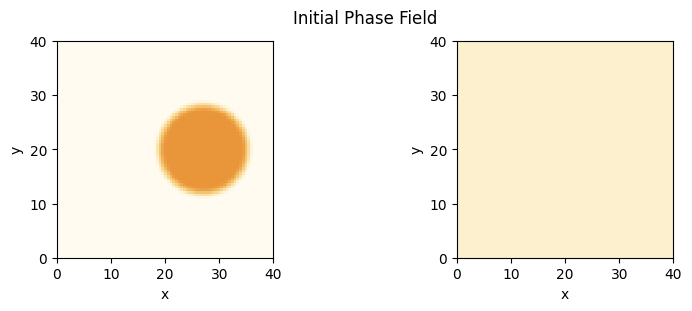

100%|██████████| 10.0/10.0 [00:11<00:00,  1.19s/it]   
100%|██████████| 11/11 [00:00<00:00, 15.81it/s]


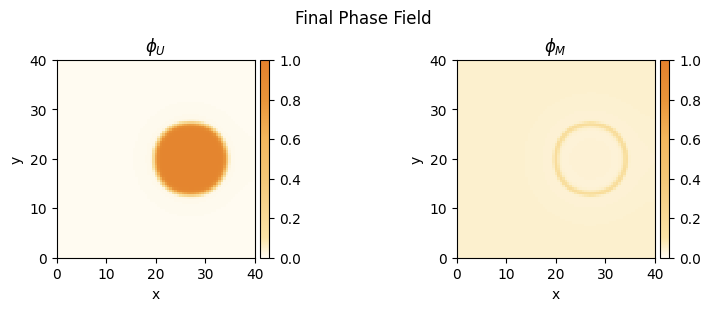

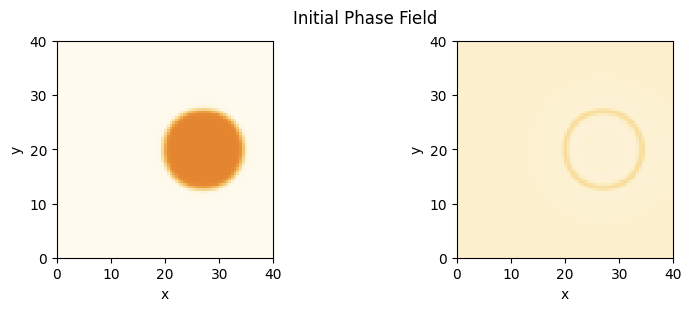

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 100.0/100.0 [00:58<00:00,  1.71it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.54it/s]


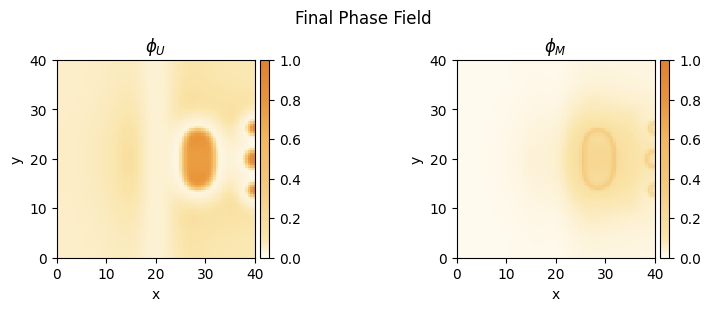

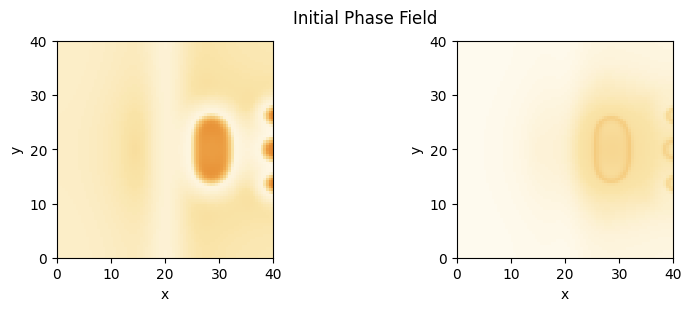

  0%|          | 0/200.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 200.0/200.0 [03:09<00:00,  1.05it/s]    
100%|██████████| 201/201 [00:11<00:00, 17.91it/s]


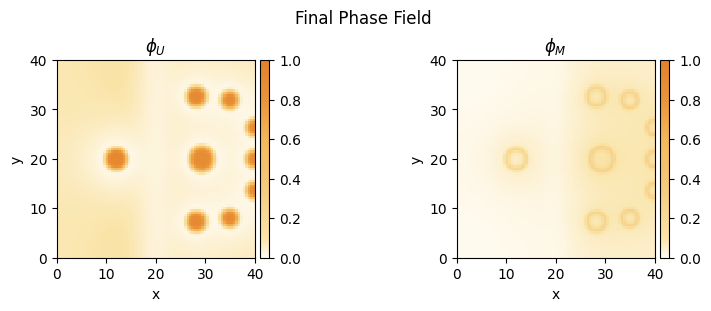

In [21]:
asym_levels = 5
x0s = np.linspace(20,27,asym_levels)
advec = [False, False, True]
for ind in range(asym_levels):
    num_phases = 3
    chem_reacts = [False, True, True]
    km_reacts = [0, 0.03, 0.03]
    chem_reacts_types = ["None", "ext_maint", "ext_maint"]
    start_from_input_files = [False, True, True]
    advec = [False, True, True]
    sim_times = [10,100, 200]
    input_filename_vec = []

    for phase in range(num_phases):
        params_advection = {
            "nx": 83,
            "ny": 83,
            "Lx": 40.0,
            "Ly": 40.0,
            "mu": 40,
            "eta": 12.5,
            "P0": 10,
            "sigma_P": 1.2
        }

        chem_react = chem_reacts[phase]
        params = {
            "k_M": km_reacts[phase] if chem_react else 0,
            "k_U": 0.03 if chem_react else 0,
            "chem_react_type": chem_reacts_types[phase] if chem_react else "None",
            "xc" : 0.5,
            "b" : 200,
            "d" : 1, #9.6 
            "kappa": 1,
            "chi" : 5, # Positive = repulsion
            "shape" : 40,
            "size" : 81,
            "simulation_time" : sim_times[phase],
            "periodic_bc" : False,
            "interval_for_tracking" : 1,
            "advection": advec[phase]
        }

        start_from_input_file = start_from_input_files[phase]
        input_folder = input_filename_vec[phase-1] if start_from_input_file else None
        input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

        # Choose initial conditions for U and M
        selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
        selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

        # Define parameters separately for U and M
        PARAMS_INIT_U = {
            "from_file":{ "filename": input_filename,
                "suffix": "_U.hdf5"
            },
            "random": {
                "phi": 0.5,
                "std": 2e-4
            },
            "single_droplet": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "radius": 8,
                "position": [x0s[ind], 20]  # Relative to shape center
            },
            "emulsion": {
                "phi": 0.5,
                "droplets": [
                    {"position": [1/3, 1/3], "radius": 8},
                    {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
                ]
            }
        }

        PARAMS_INIT_M = {
                "from_file":{ "filename": input_filename,
                "suffix": "_M.hdf5",
            },
            "random": {
                "phi": 0.05,
                "std": 2e-4
            },
            "single_droplet": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "radius": 8,
                "position": [25, 25]  # Relative to shape center
            },
            "emulsion": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "droplets": [
                    {"position": [1/3, 1/3], "radius": 7.5},
                    {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
                ]
            }
        }


        save_final_config = True
        ### Save params ###
        if save_final_config:
            run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
            output_folder = f"simulation_results/Paper/definite/asymmetric/PTMs/{run_name}/"
            input_filename_vec.append(output_folder)
            os.makedirs(output_folder, exist_ok=True)

            with open(f"{output_folder}/params.json", "w") as f:
                json.dump(params, f, indent=4)
            if params["advection"]:
                with open(f"{output_folder}/params_advection.json", "w") as f:
                    json.dump(params_advection, f, indent=4)
        output_filename = output_folder+f"final_config"

        P, u, x, y, X, Y = solve_stokes_flow(**params_advection)

        sol, solver_info = run_simulation(selected_init_cond_U,
            selected_init_cond_M,
            PARAMS_INIT_U[selected_init_cond_U],
            PARAMS_INIT_M[selected_init_cond_M],
            save_final_config, input_filename, output_filename, output_folder, chem_react, u = u, cmapcolor = cmap_orange, **params)


## Multiphase droplet simulation

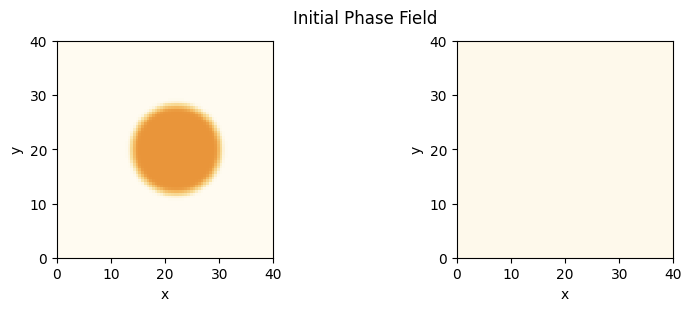

100%|██████████| 100.0/100.0 [00:59<00:00,  1.68it/s]    
100%|██████████| 101/101 [00:05<00:00, 18.05it/s]


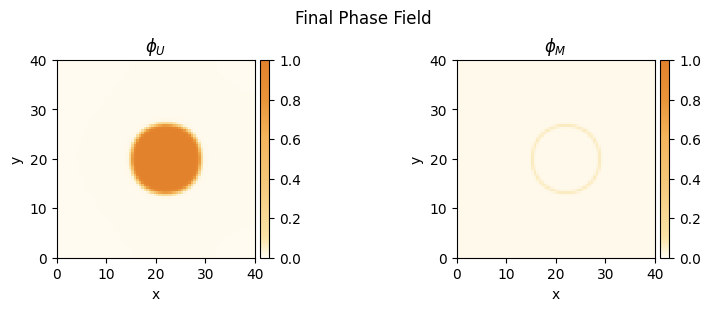

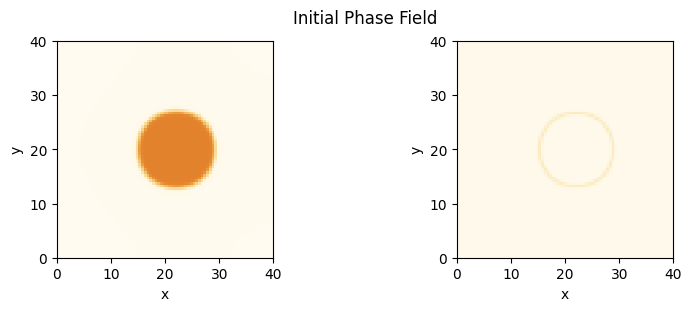

100%|██████████| 50.0/50.0 [00:34<00:00,  1.45it/s]    
100%|██████████| 51/51 [00:02<00:00, 18.25it/s]


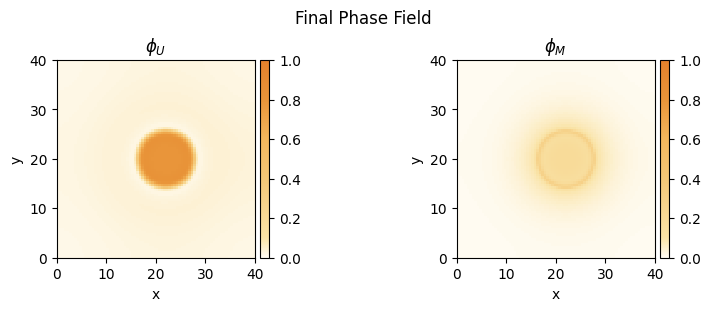

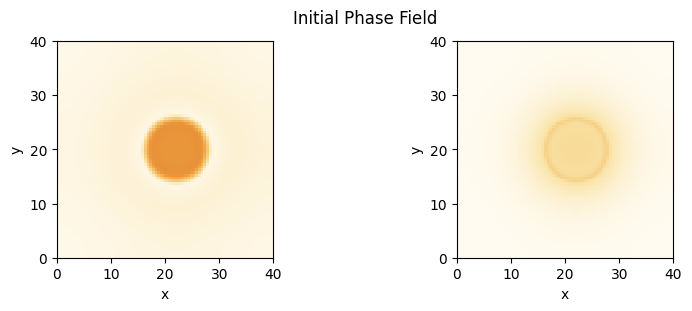

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 100.0/100.0 [01:22<00:00,  1.21it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.74it/s]


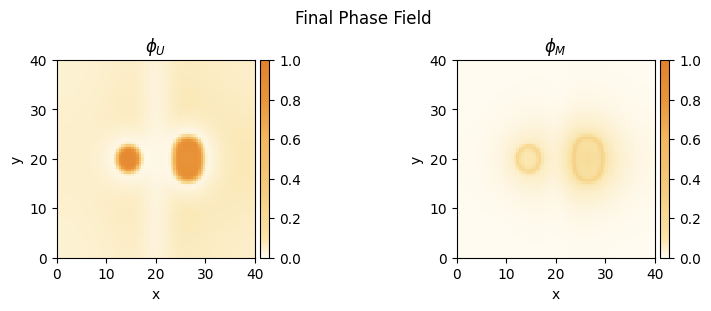

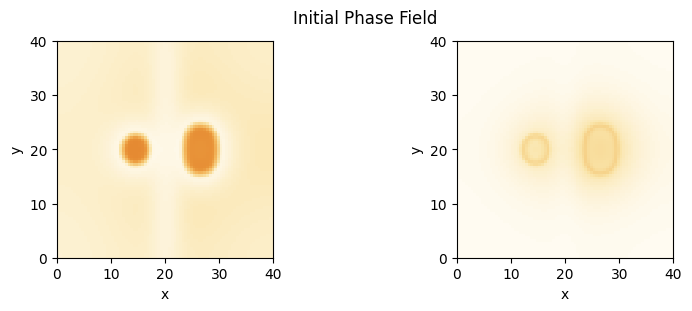

  0%|          | 0/300.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 300.0/300.0 [05:03<00:00,  1.01s/it]    
100%|██████████| 301/301 [00:16<00:00, 18.21it/s]


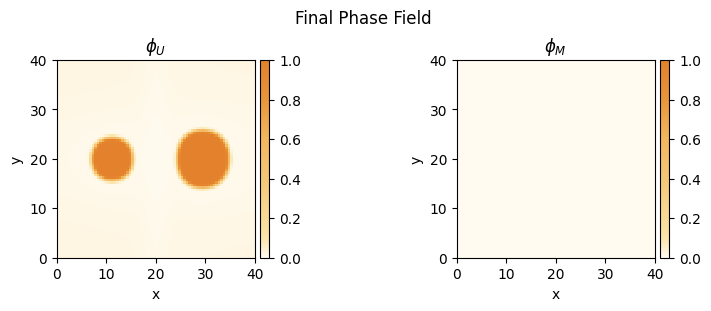

In [ ]:
num_phases = 4
chem_reacts = [False, True, True, True]
km_reacts = [0, 0.05, 0.05, 0]
chem_reacts_types = ["None", "ext_maint", "ext_maint", "ext_maint"]
start_from_input_files = [False, True, True, True]
advec = [False, False, True, True]
sim_times = [100,50,100,300]
input_filename_vec = []

for phase in range(num_phases):

    chem_react = chem_reacts[phase]
    params = {
        "k_M": km_reacts[phase] if chem_react else 0,
        "k_U": 0.05 if chem_react else 0,
        "chem_react_type": chem_reacts_types[phase] if chem_react else "None",
        "xc" : 0.8,
        "b" : 200,
        "a" : 1.5,
        "x0" : 20,
        "c" : 1,
        "d" : 1, #9.6 
        "kappa": 1,
        "chi" : 5, # Positive = repulsion
        "dim" : 2,
        "shape" : 40,
        "size" : 80,
 
        "simulation_time" : sim_times[phase],
        "periodic_bc" : False,
        "interval_for_tracking" : 1,
        "advection": advec[phase]
    }

    start_from_input_file = start_from_input_files[phase]
    input_folder = input_filename_vec[phase-1] if start_from_input_file else None
    input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

    # Choose initial conditions for U and M
    selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
    selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

    # Define parameters separately for U and M
    PARAMS_INIT_U = {
        "from_file":{ "filename": input_filename,
            "suffix": "_U.hdf5"
        },
        "random": {
            "phi": 0.5,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [22, 20]  # Relative to shape center
        },
        "emulsion": {
            "phi": 0.5,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 8},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
            ]
        }
    }

    PARAMS_INIT_M = {
            "from_file":{ "filename": input_filename,
            "suffix": "_M.hdf5",
        },
        "random": {
            "phi": 0.01,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [30, 20]  # Relative to shape center
        },
        "emulsion": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 7.5},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
            ]
        }
    }


    save_final_config = True
    ### Save params ###
    if save_final_config:
        run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        output_folder = f"simulation_results/4_May/Heidelberg/{run_name}/"
        input_filename_vec.append(output_folder)
        os.makedirs(output_folder, exist_ok=True)

        with open(f"{output_folder}/params.json", "w") as f:
            json.dump(params, f, indent=4)
        if params["advection"]:
            with open(f"{output_folder}/params_advection.json", "w") as f:
                json.dump(params_advection, f, indent=4)
    output_filename = output_folder+f"final_config"


    sol = run_simulation(selected_init_cond_U,
        selected_init_cond_M,
        PARAMS_INIT_U[selected_init_cond_U],
        PARAMS_INIT_M[selected_init_cond_M],
        start_from_input_file, save_final_config, input_filename, output_filename, output_folder, chem_react, cmapcolor = cmap_orange,  **params)


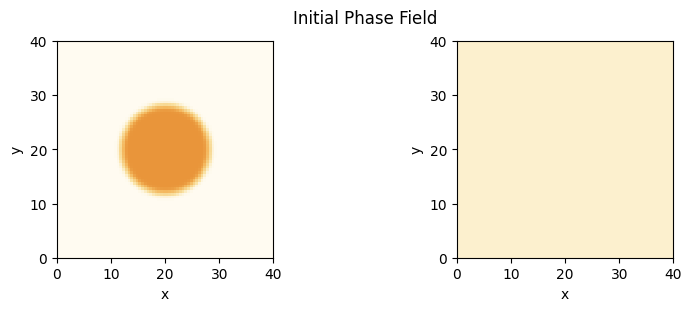

  0%|          | 0/400.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 400.0/400.0 [03:14<00:00,  2.06it/s]    
100%|██████████| 41/41 [00:02<00:00, 17.02it/s]


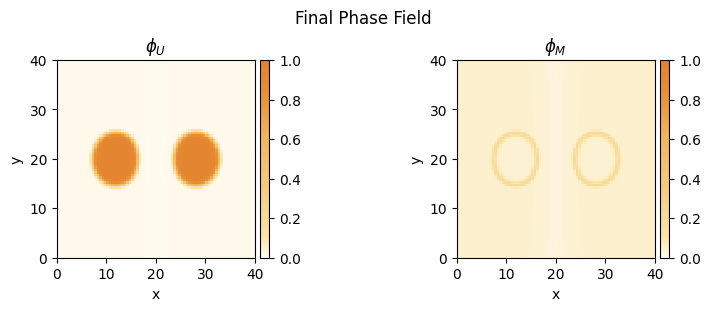

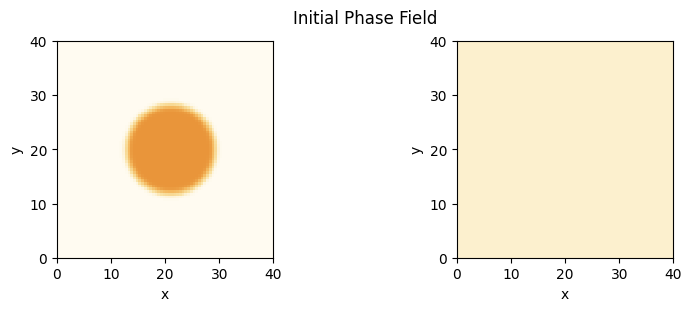

  0%|          | 0/400.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 400.0/400.0 [03:16<00:00,  2.04it/s]    
100%|██████████| 41/41 [00:02<00:00, 17.71it/s]


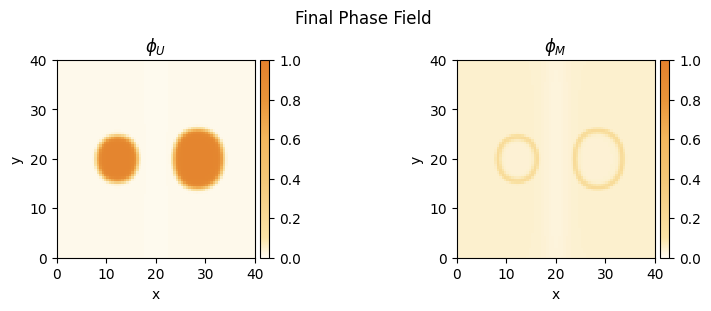

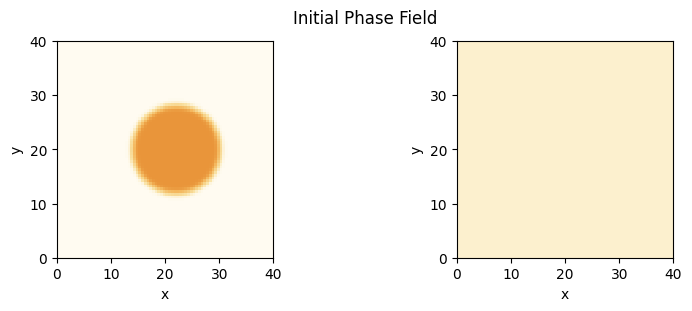

  0%|          | 0/400.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 400.0/400.0 [03:17<00:00,  2.02it/s]    
100%|██████████| 41/41 [00:02<00:00, 17.74it/s]


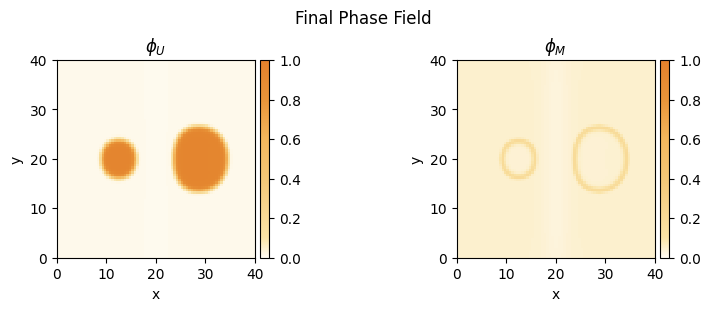

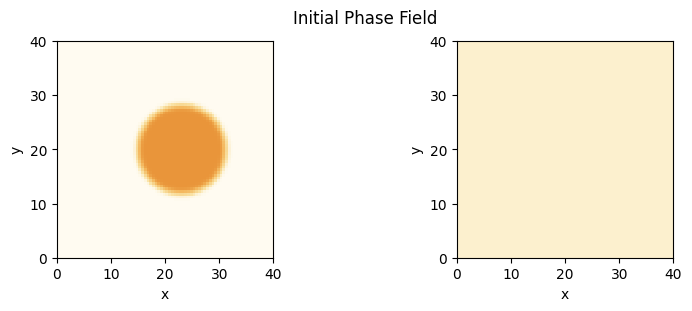

  0%|          | 0/400.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 400.0/400.0 [03:17<00:00,  2.03it/s]    
100%|██████████| 41/41 [00:02<00:00, 17.83it/s]


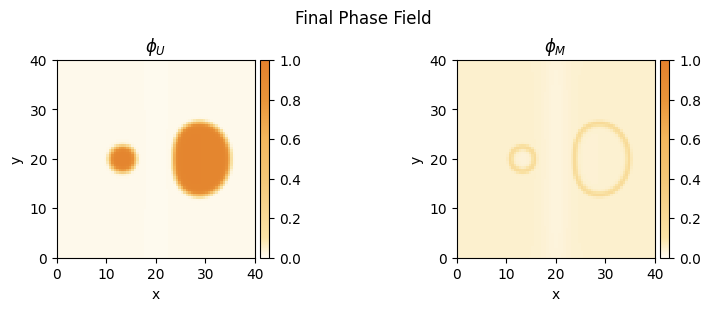

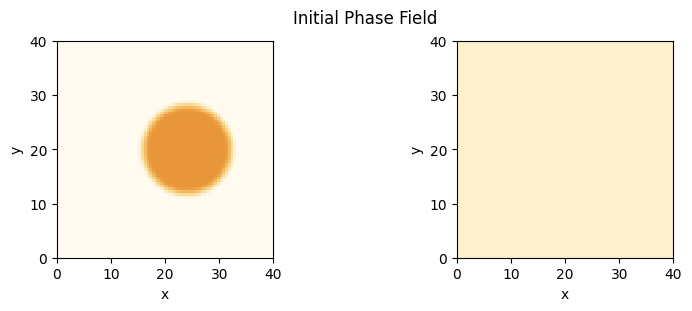

  0%|          | 0/400.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 400.0/400.0 [03:11<00:00,  2.09it/s]    
100%|██████████| 41/41 [00:02<00:00, 17.83it/s]


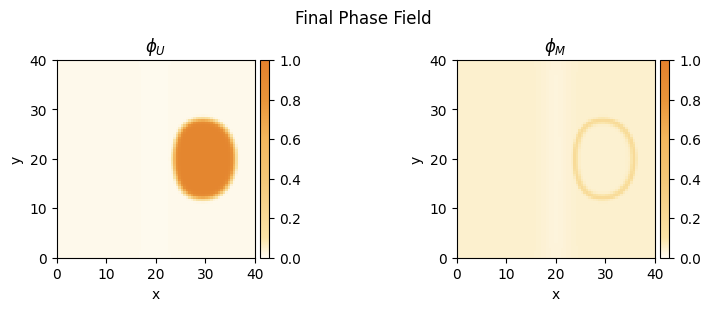

In [ ]:
asym_levels = 5
chem_reacts_types = ["None", "ext_maint", "ext_maint", "ext_maint"]
x0s = np.linspace(20,24,asym_levels)
input_filename_vec = []

for ind in range(asym_levels):

    chem_react = False
    params = {
        "k_M": 0.05 if chem_react else 0,
        "k_U": 0.05 if chem_react else 0,
        "chem_react_type": "ext_maint" if chem_react else "None",
        "xc" : 0.8,
        "b" : 200,
        "a" : 1.5,
        "x0" : 20,
        "c" : 1,
        "d" : 1, #9.6 
        "kappa": 1,
        "chi" : 5, # Positive = repulsion
        "dim" : 2,
        "shape" : 40,
        "size" : 80,
 
        "simulation_time" : 400,
        "periodic_bc" : False,
        "interval_for_tracking" : 10,
        "advection": True
    }

    start_from_input_file = False
    input_folder = input_filename_vec if start_from_input_file else None
    input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

    # Choose initial conditions for U and M
    selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
    selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

    # Define parameters separately for U and M
    PARAMS_INIT_U = {
        "from_file":{ "filename": input_filename,
            "suffix": "_U.hdf5"
        },
        "random": {
            "phi": 0.5,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [x0s[ind], 20]  # Relative to shape center
        },
        "emulsion": {
            "phi": 0.5,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 8},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
            ]
        }
    }

    PARAMS_INIT_M = {
            "from_file":{ "filename": input_filename,
            "suffix": "_M.hdf5",
        },
        "random": {
            "phi": 0.05,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [30, 20]  # Relative to shape center
        },
        "emulsion": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 7.5},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
            ]
        }
    }


    save_final_config = True
    ### Save params ###
    if save_final_config:
        run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        output_folder = f"simulation_results/4_May/Heidelberg/various_asym_PTMs/{run_name}/"
        input_filename_vec.append(output_folder)
        os.makedirs(output_folder, exist_ok=True)

        with open(f"{output_folder}/params.json", "w") as f:
            json.dump(params, f, indent=4)
        if params["advection"]:
            with open(f"{output_folder}/params_advection.json", "w") as f:
                json.dump(params_advection, f, indent=4)
    output_filename = output_folder+f"final_config"


    sol = run_simulation(selected_init_cond_U,
        selected_init_cond_M,
        PARAMS_INIT_U[selected_init_cond_U],
        PARAMS_INIT_M[selected_init_cond_M],
        start_from_input_file, save_final_config, input_filename, output_filename, output_folder, chem_react, cmapcolor = cmap_orange,  **params)


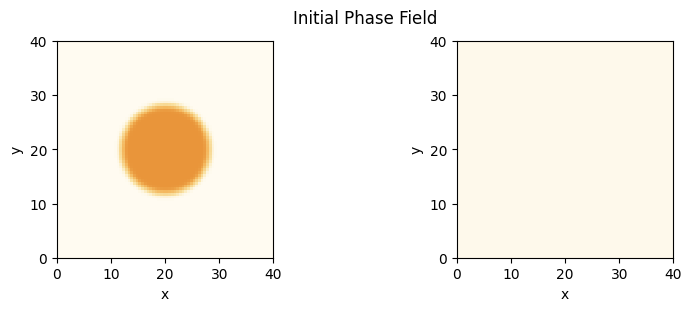

100%|██████████| 10.0/10.0 [00:12<00:00,  1.26s/it]   
100%|██████████| 11/11 [00:00<00:00, 15.34it/s]


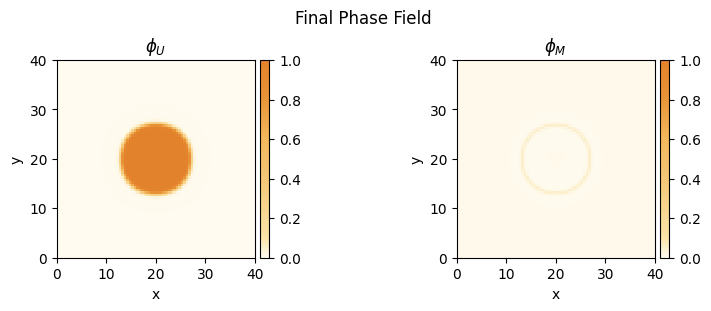

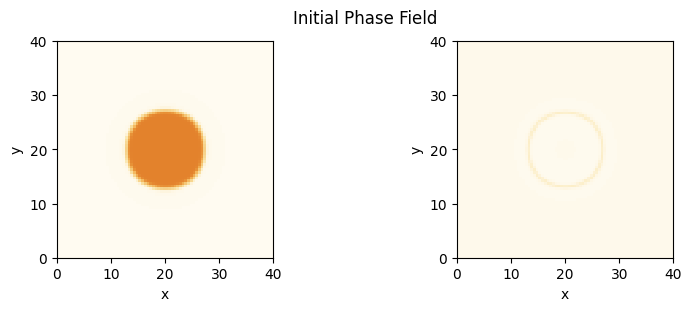

100%|██████████| 50.0/50.0 [00:36<00:00,  1.37it/s]    
100%|██████████| 51/51 [00:02<00:00, 17.81it/s]


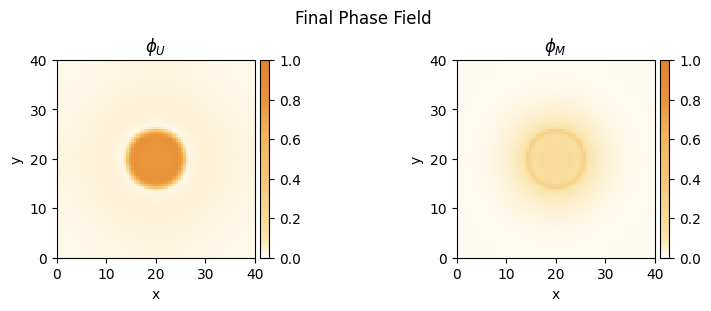

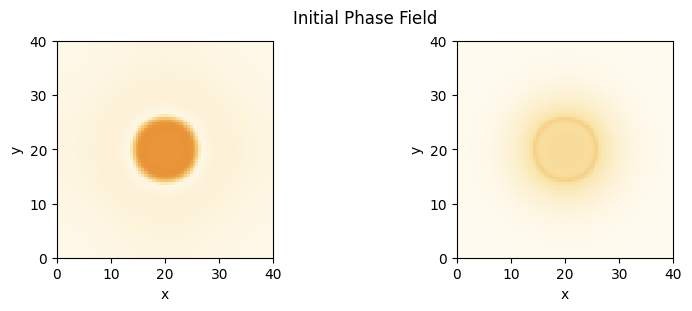

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 100.0/100.0 [01:10<00:00,  1.42it/s]    
100%|██████████| 101/101 [00:05<00:00, 18.33it/s]


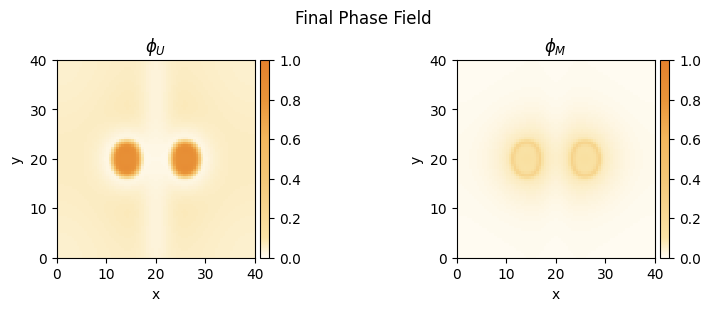

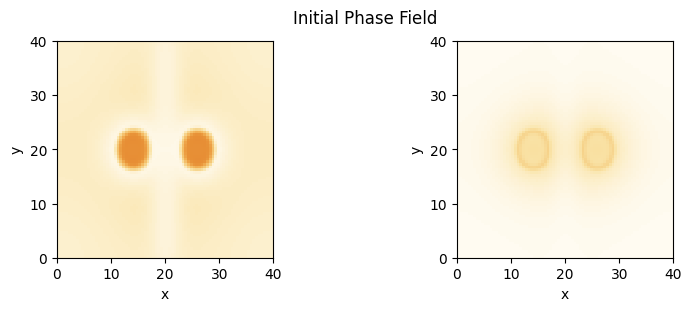

  0%|          | 0/300.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 300.0/300.0 [04:57<00:00,  1.01it/s]    
100%|██████████| 301/301 [00:16<00:00, 17.81it/s]


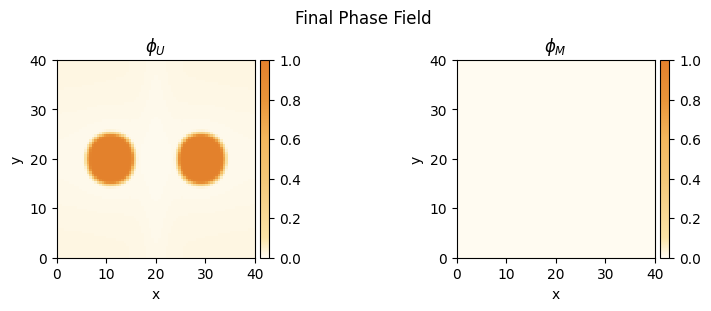

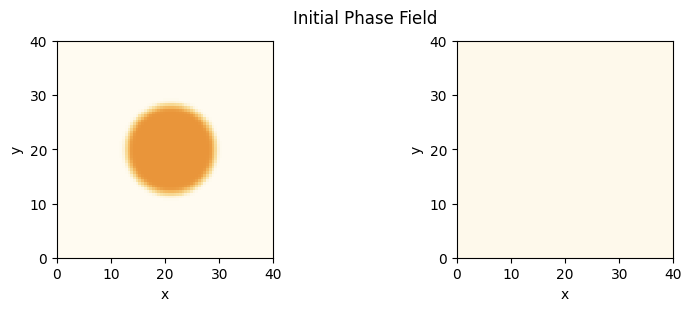

100%|██████████| 10.0/10.0 [00:11<00:00,  1.16s/it]   
100%|██████████| 11/11 [00:00<00:00, 15.74it/s]


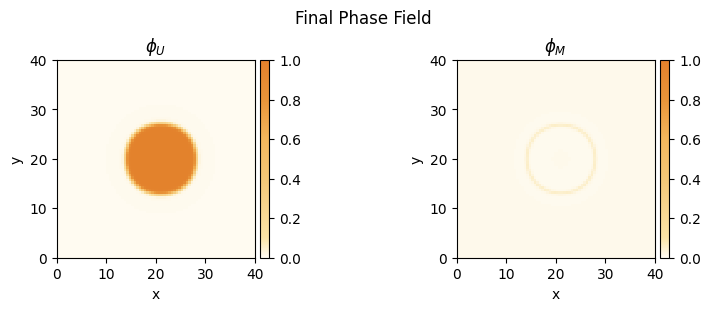

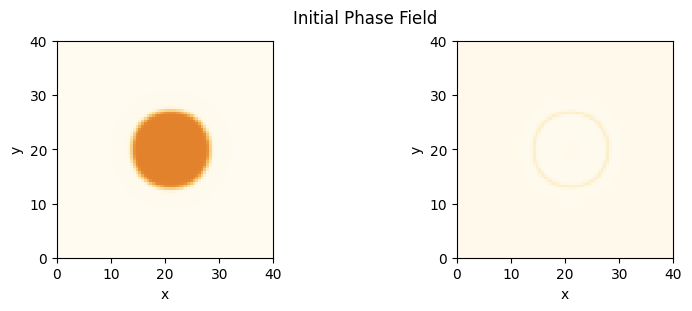

100%|██████████| 50.0/50.0 [00:35<00:00,  1.40it/s]    
100%|██████████| 51/51 [00:02<00:00, 18.12it/s]


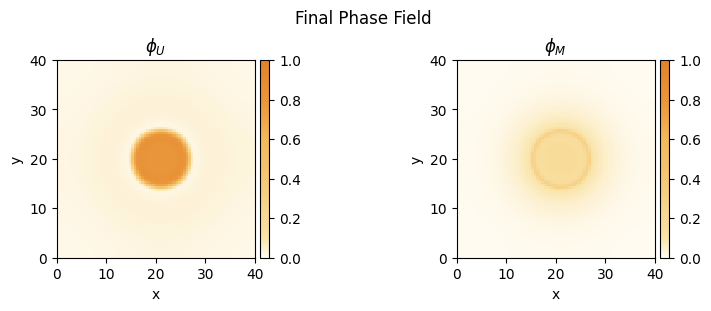

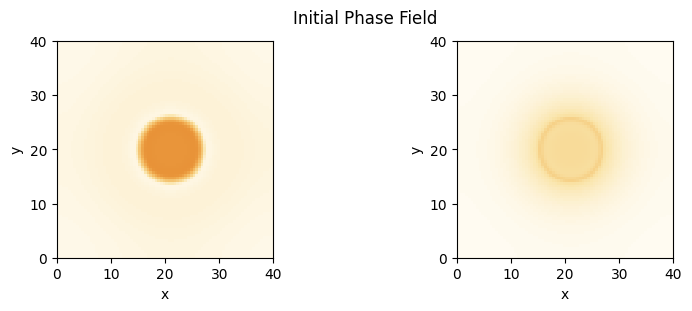

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 100.0/100.0 [01:17<00:00,  1.29it/s]    
100%|██████████| 101/101 [00:05<00:00, 18.15it/s]


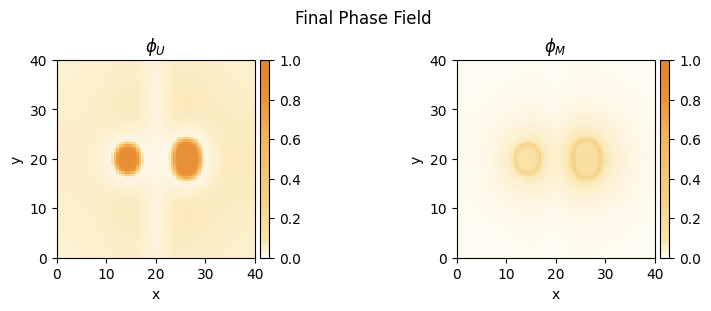

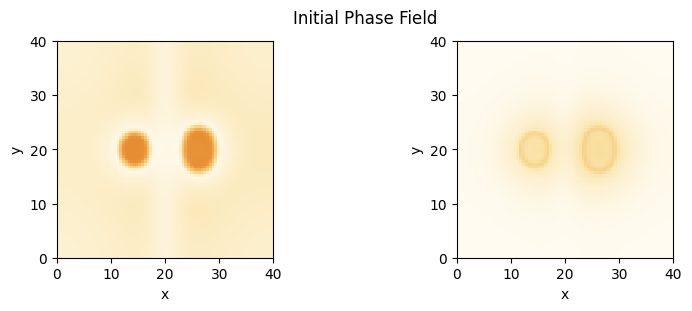

  0%|          | 0/300.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 300.0/300.0 [05:00<00:00,  1.00s/it]    
100%|██████████| 301/301 [00:16<00:00, 18.05it/s]


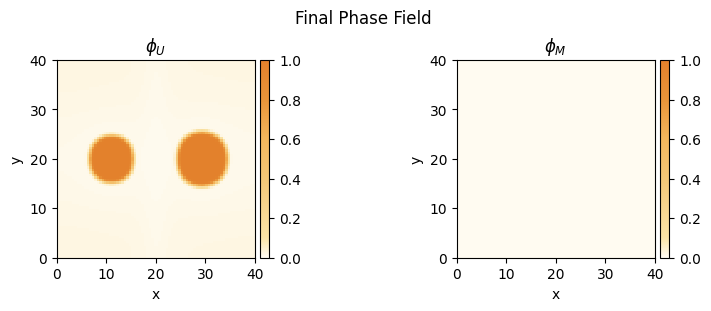

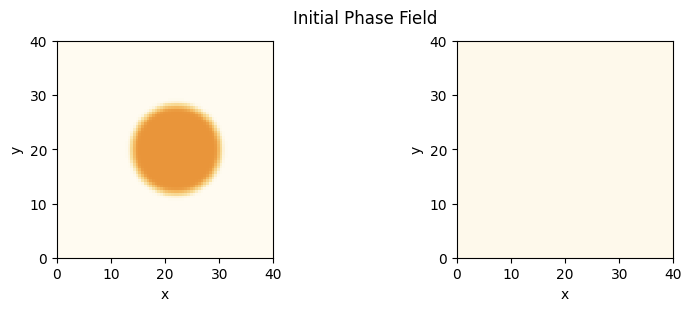

100%|██████████| 10.0/10.0 [00:13<00:00,  1.33s/it]   
100%|██████████| 11/11 [00:00<00:00, 15.43it/s]


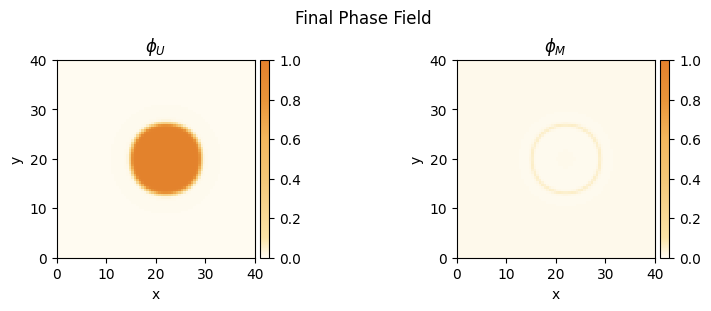

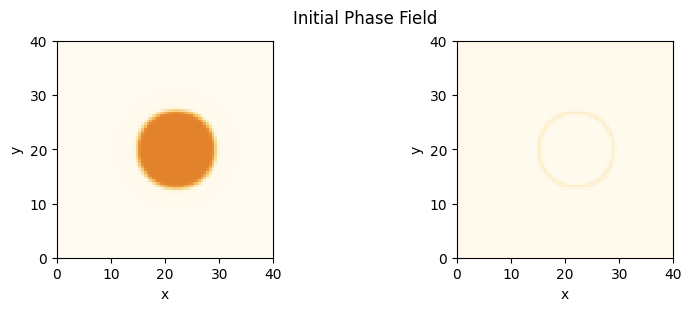

100%|██████████| 50.0/50.0 [00:37<00:00,  1.33it/s]     
100%|██████████| 51/51 [00:02<00:00, 17.82it/s]


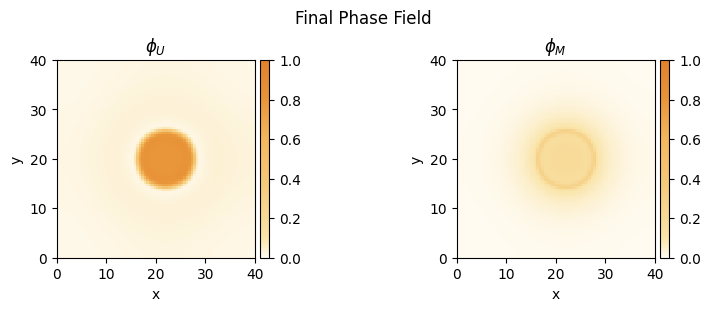

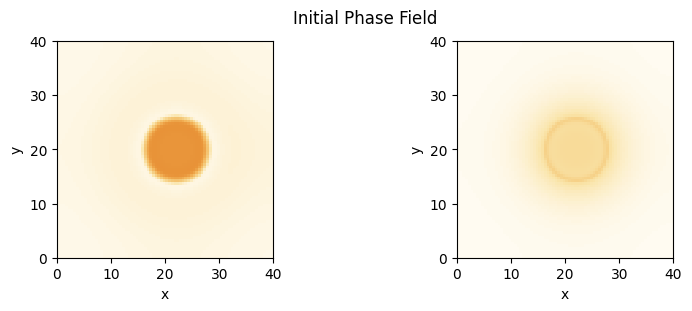

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 100.0/100.0 [01:23<00:00,  1.19it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.82it/s]


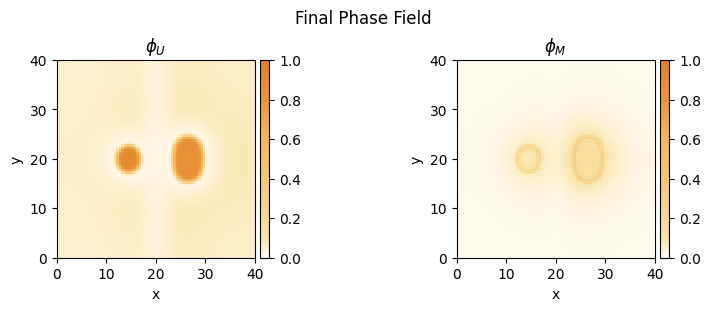

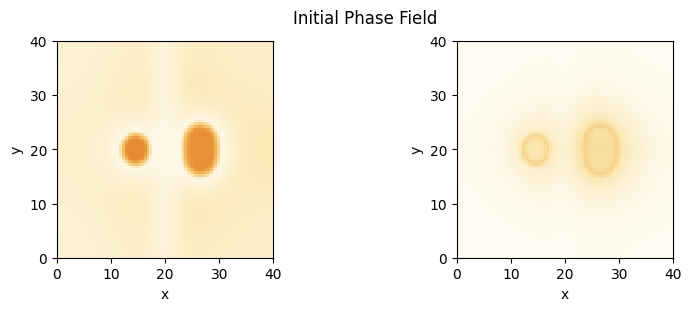

  0%|          | 0/300.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 300.0/300.0 [05:05<00:00,  1.02s/it]    
100%|██████████| 301/301 [00:16<00:00, 18.10it/s]


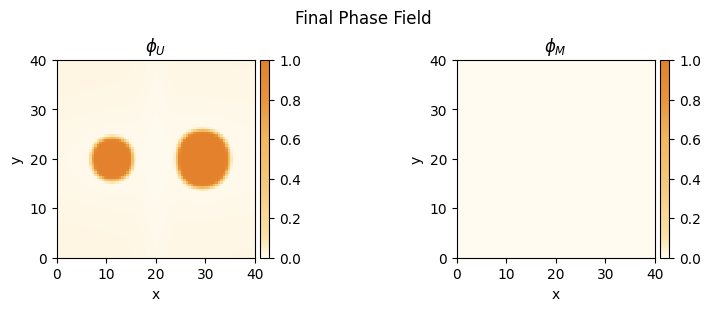

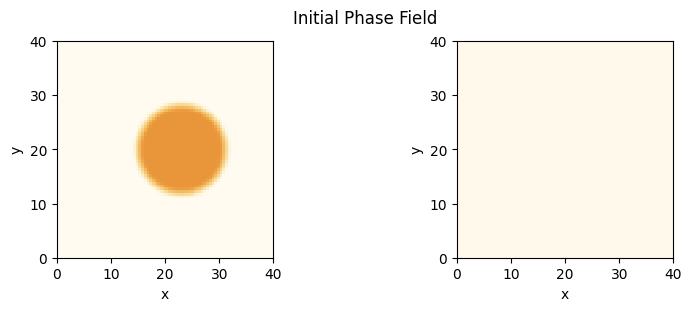

100%|██████████| 10.0/10.0 [00:12<00:00,  1.21s/it]   
100%|██████████| 11/11 [00:00<00:00, 15.65it/s]


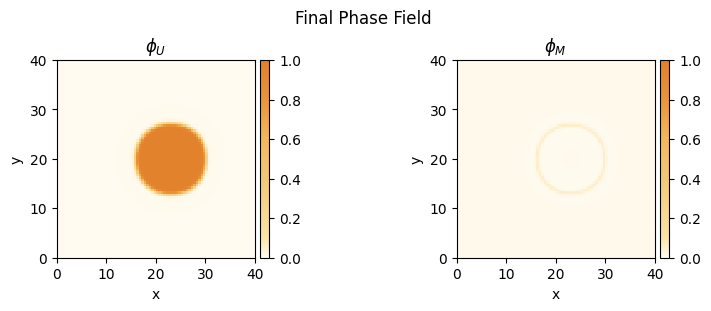

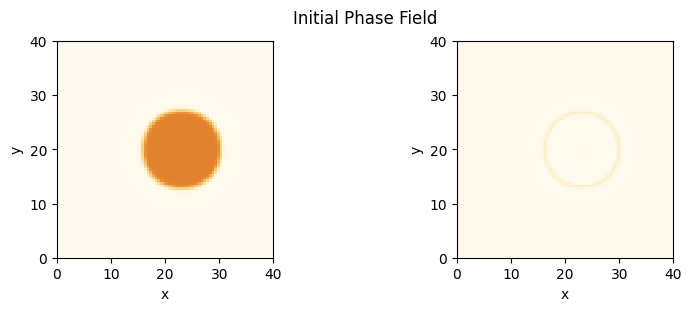

100%|██████████| 50.0/50.0 [00:38<00:00,  1.31it/s]     
100%|██████████| 51/51 [00:02<00:00, 17.56it/s]


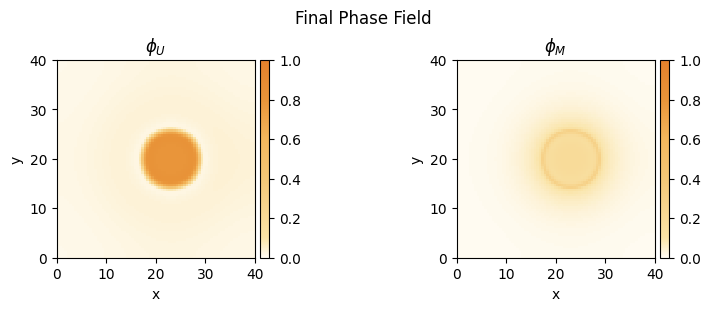

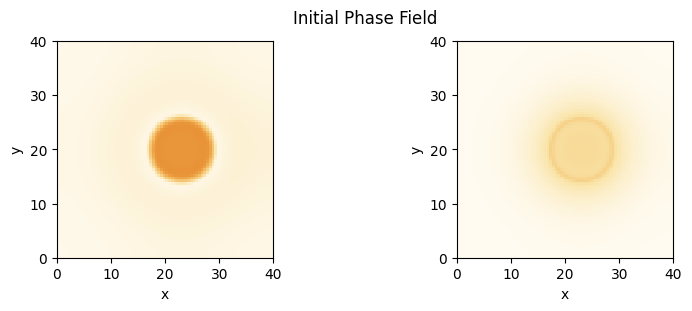

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 100.0/100.0 [01:22<00:00,  1.21it/s]    
100%|██████████| 101/101 [00:05<00:00, 18.07it/s]


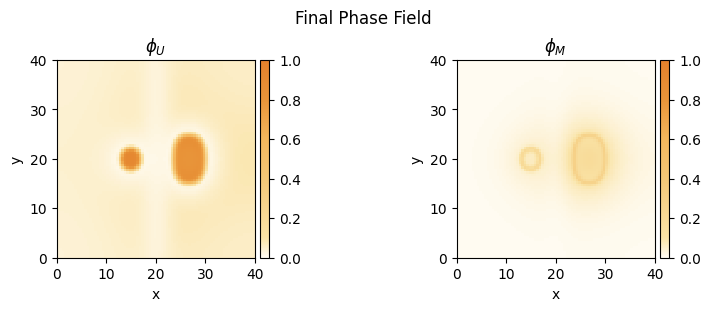

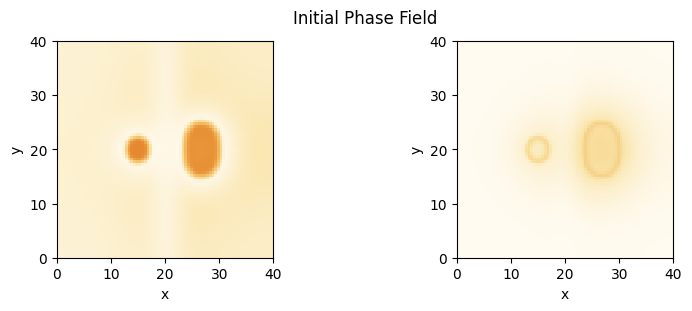

  0%|          | 0/300.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 300.0/300.0 [05:09<00:00,  1.03s/it]    
100%|██████████| 301/301 [00:16<00:00, 18.35it/s]


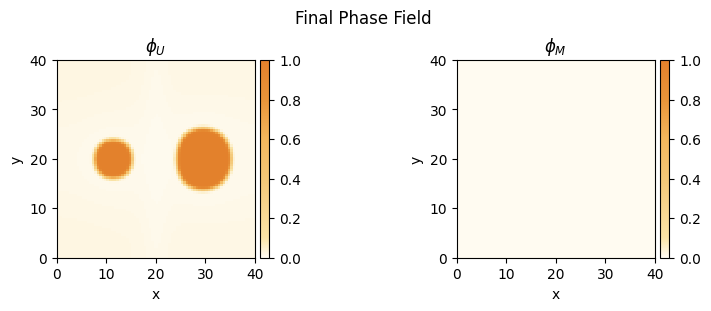

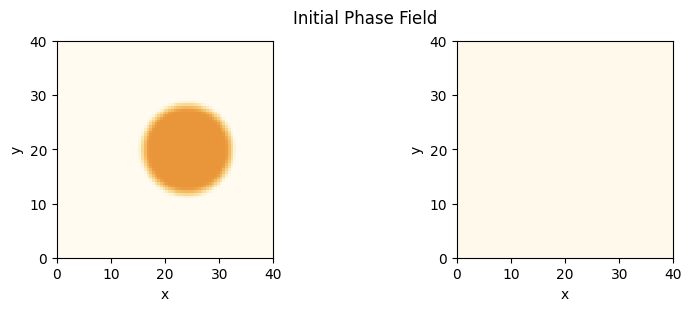

100%|██████████| 10.0/10.0 [00:11<00:00,  1.18s/it]   
100%|██████████| 11/11 [00:00<00:00, 16.98it/s]


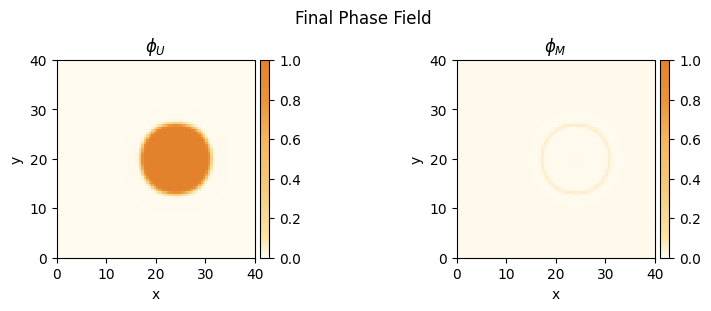

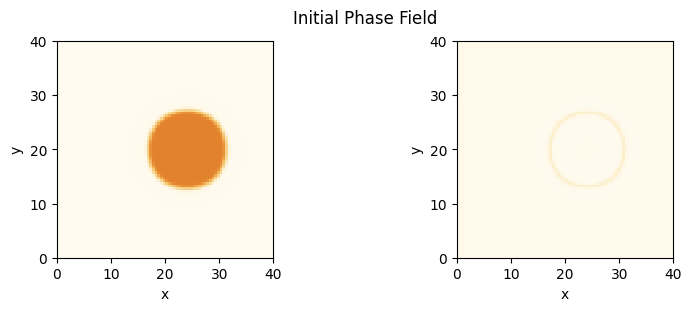

100%|██████████| 50.0/50.0 [00:36<00:00,  1.36it/s]    
100%|██████████| 51/51 [00:02<00:00, 17.18it/s]


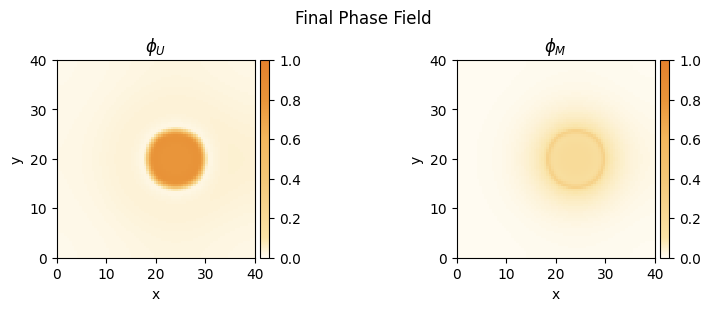

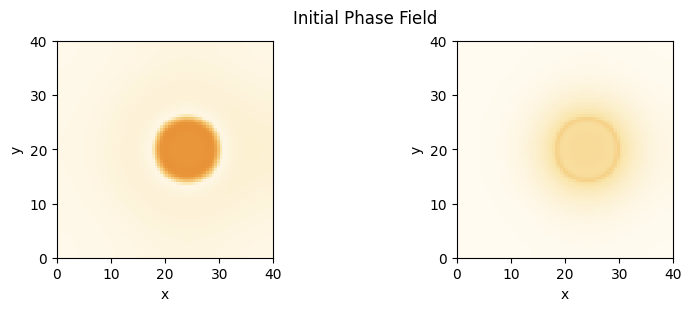

  0%|          | 0/100.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 100.0/100.0 [01:08<00:00,  1.46it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.63it/s]


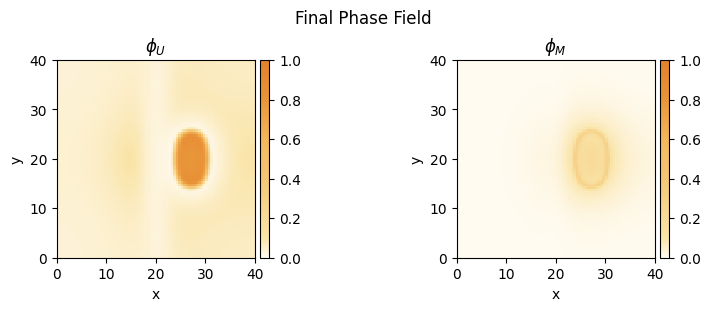

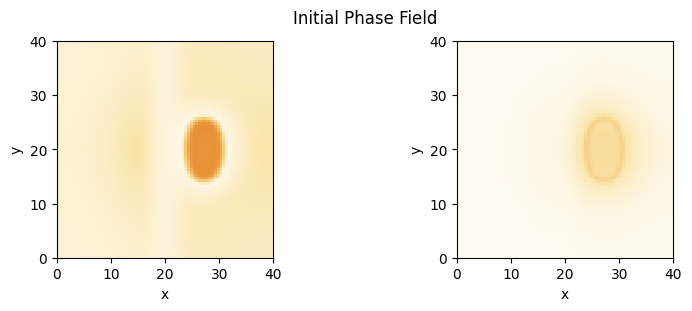

  0%|          | 0/300.0 [00:00<?, ?it/s]              

dimx, dimy 80 80


100%|██████████| 300.0/300.0 [04:51<00:00,  1.03it/s]    
100%|██████████| 301/301 [00:16<00:00, 18.23it/s]


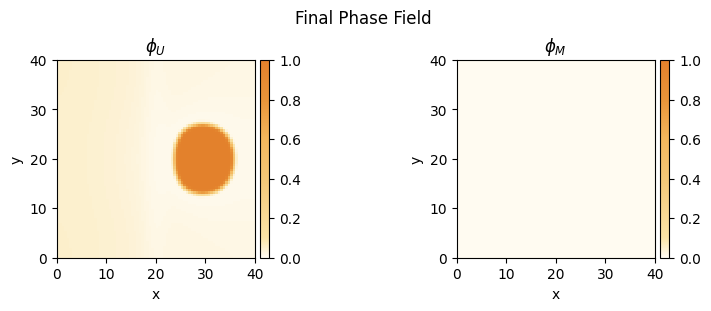

In [ ]:
asym_levels = 5
x0s = np.linspace(20,24,asym_levels)
num_phases = 4
chem_reacts = [False, True, True, True]
km_reacts = [0, 0.05, 0.05, 0]
chem_reacts_types = ["None", "ext_maint", "ext_maint", "ext_maint"]
start_from_input_files = [False, True, True, True]
advec = [False, False, True, True]
sim_times = [10,50,100,300]

for ind in range(asym_levels):
    input_filename_vec = []
    for phase in range(num_phases):

        chem_react = chem_reacts[phase]
        params = {
            "k_M": km_reacts[phase] if chem_react else 0,
            "k_U": 0.05 if chem_react else 0,
            "chem_react_type": chem_reacts_types[phase] if chem_react else "None",
            "xc" : 0.8,
            "b" : 200,
            "a" : 1.5,
            "x0" : 20,
            "c" : 1,
            "d" : 1, #9.6 
            "kappa": 1,
            "chi" : 5, # Positive = repulsion
            "dim" : 2,
            "shape" : 40,
            "size" : 80,
    
            "simulation_time" : sim_times[phase],
            "periodic_bc" : False,
            "interval_for_tracking" : 1,
            "advection": advec[phase]
        }

        start_from_input_file = start_from_input_files[phase]
        input_folder = input_filename_vec[phase-1] if start_from_input_file else None
        input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

        # Choose initial conditions for U and M
        selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
        selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

        # Define parameters separately for U and M
        PARAMS_INIT_U = {
            "from_file":{ "filename": input_filename,
                "suffix": "_U.hdf5"
            },
            "random": {
                "phi": 0.5,
                "std": 2e-4
            },
            "single_droplet": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "radius": 8,
                "position": [x0s[ind], 20]  # Relative to shape center
            },
            "emulsion": {
                "phi": 0.5,
                "droplets": [
                    {"position": [1/3, 1/3], "radius": 8},
                    {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
                ]
            }
        }

        PARAMS_INIT_M = {
                "from_file":{ "filename": input_filename,
                "suffix": "_M.hdf5",
            },
            "random": {
                "phi": 0.01,
                "std": 2e-4
            },
            "single_droplet": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "radius": 8,
                "position": [30, 20]  # Relative to shape center
            },
            "emulsion": {
                "phi_out": 0.0001,
                "phi_in": 0.8,
                "droplets": [
                    {"position": [1/3, 1/3], "radius": 7.5},
                    {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
                ]
            }
        }


        save_final_config = True
        ### Save params ###
        if save_final_config:
            run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
            output_folder = f"simulation_results/4_May/Heidelberg/various_asym_PTMs/{run_name}_{phase}/"
            input_filename_vec.append(output_folder)
            os.makedirs(output_folder, exist_ok=True)

            with open(f"{output_folder}/params.json", "w") as f:
                json.dump(params, f, indent=4)
            if params["advection"]:
                with open(f"{output_folder}/params_advection.json", "w") as f:
                    json.dump(params_advection, f, indent=4)
        output_filename = output_folder+f"final_config"


        sol = run_simulation(selected_init_cond_U,
            selected_init_cond_M,
            PARAMS_INIT_U[selected_init_cond_U],
            PARAMS_INIT_M[selected_init_cond_M],
            start_from_input_file, save_final_config, input_filename, output_filename, output_folder, chem_react, cmapcolor = cmap_orange,  **params)
